This notebook illustrates some experiments on identifying significant points on a persistence diagram on V1. 


In [1]:
using Pkg
Pkg.activate("../../env/.")

  Activating project at `~/analogous_neural/env`


In [2]:
Pkg.instantiate()

In [3]:
include("../../src/analogous_bars.jl")
include("../../src/Eirene_var.jl")

using .analogous_bars
using .Eirene_var
using DelimitedFiles
using HDF5
using Plots
using FileIO
using MultivariateStats
using PersistenceDiagrams
using StatsBase
using Random

WebIO._IJuliaInit()

[ Info: Precompiling PersistenceDiagrams [90b4794c-894b-4756-a0f8-5efeb5ddf7ae]


In [4]:
function get_PD_significance_threshold_subsampling(D; alpha = 0.05, n_samples = 1000)
    
    # compute PD from original matrix
    C = eirene(D, maxdim = 1)
    barcode_C = Eirene_var.barcode(C, dim = 1)
    PD_original = array_to_ripsererPD(barcode_C)

    emp = []
    n_D = size(D,1)
    for i = 1:n_samples
        # sample rows and columns, with replacement
        subsample = sample(1:n_D, n_D, replace = true)
        D_sub = D[subsample,subsample]

        # compute new PD from subsampled distance
        C_sub = eirene(D_sub, maxdim = 1)
        barc = Eirene_var.barcode(C_sub, dim = 1)
        PD_new = array_to_ripsererPD(barc)

        # compute bottleneck distance
        bottleneck_distance = Bottleneck()(PD_original, PD_new)
        append!(emp, bottleneck_distance)
    end

    threshold = quantile(emp, 1-alpha)
    return threshold, emp
end

get_PD_significance_threshold_subsampling (generic function with 1 method)

In [5]:

array_to_ripsererPD(PD_array) = PersistenceDiagram([(PD_array[i,1], PD_array[i,2]) for i = 1:size(PD_array,1)])

array_to_ripsererPD (generic function with 1 method)

In [6]:
# load dissimilarity
total_D = readdlm("data/total_dissimilarity.csv")

# get number of neurons in AL
AL_txt = open("data/AL_neurons_idx.txt", "r")
AL_linebyline = readlines(AL_txt)
close(AL_txt)
n_AL = size(AL_linebyline, 1)

# get number of neurons in V1
V1_txt = open("data/V1_neurons_idx.txt", "r")
V1_linebyline = readlines(V1_txt)
close(V1_txt)
n_V1 = size(V1_linebyline, 1)

# Define submatrices 
D_V1 = total_D[1:n_V1, 1:n_V1]
D_AL = total_D[n_V1+1:end, n_V1+1:end]
D_V1_AL = total_D[1:n_V1, n_V1+1:end]
    # rows (landmarks): V1
    # columns (witness) : AL
D_AL_V1 = total_D[n_V1+1:end, 1:n_V1];
    # rows (landmarks): AL
    # columns (witness) : V1

In [7]:
# compute persistence diagrams 
C_V1 = eirene(D_V1, record = "all", maxdim = 1)
C_AL = eirene(D_AL, record = "all", maxdim = 1)
W_V1 = compute_Witness_persistence(D_V1_AL)

barcode_V1 = Eirene_var.barcode(C_V1, dim = 1)
barcode_AL = Eirene_var.barcode(C_AL, dim = 1)
barcode_W_V1_AL = Eirene_var.barcode(W_V1["eirene_output"], dim = 1);

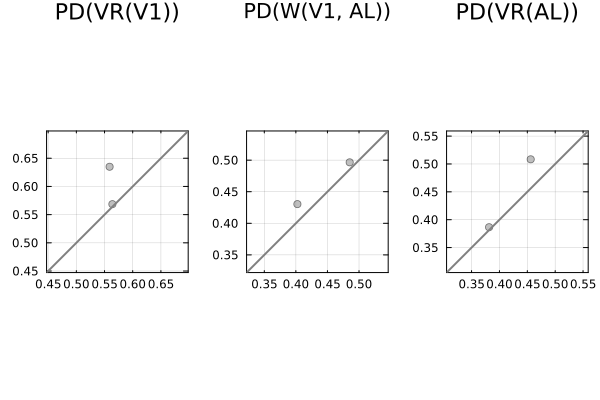

In [8]:
# plot persistence diagrams
p1 = plot_PD(barcode_V1, title = "PD(VR(V1))", titlefontsize = 15)
p2 = plot_PD(barcode_W_V1_AL, title = "PD(W(V1, AL))")
p3 = plot_PD(barcode_AL, title = "PD(VR(AL))", titlefontsize = 15)
plot(p1, p2, p3, layout = grid(1,3))

In [19]:
barcode_V1[:,2] - barcode_V1[:,1]

2-element Vector{Float64}:
 0.004631247558401164
 0.07591642300364132

In [59]:
barcode_AL[:,2] - barcode_AL[:,1]

2-element Vector{Float64}:
 0.005141065599194916
 0.05230193200890898

# Bootstrap from dissimilarity matrix

In [9]:
function get_barlength_distribution_from_bootstrap(D; alpha = 0.05, n_samples = 10000)
    emp = []
    n_D = size(D,1)
    for i = 1:n_samples
        subsample = sample(1:n_D, n_D, replace = true)
        D_sub = D[subsample,subsample]
        C_sub = eirene(D_sub, maxdim = 1)
        barc = barcode(C_sub, dim = 1)
        bar_lengths = barc[:,2]-barc[:,1] 
        append!(emp, bar_lengths)
    end
    
    min_length = quantile(emp, 1-alpha)
    return min_length, emp
    
end

get_barlength_distribution_from_bootstrap (generic function with 1 method)

In [12]:
function get_barlength_distribution_from_bootstrap2(D; alpha = 0.05, n_samples = 50000)
    emp = []
    n_D = size(D,1)
    for i = 1:n_samples
        subsample = sample(1:n_D, n_D, replace = true)
        D_sub = D[subsample,subsample]
        C_sub = eirene(D_sub, maxdim = 1)
        barc = Eirene_var.barcode(C_sub, dim = 1)
        bar_lengths = barc[:,2]-barc[:,1] 
        append!(emp, mean(bar_lengths))
    end

    # replace NaN (resulting from empty barcodes) with 0
    emp_replaced_NaN = []
    for i in emp
        if isnan(i) == true
            append!(emp_replaced_NaN, 0)
        else
            append!(emp_replaced_NaN,i)
        end
    end
        
    min_length = quantile(emp_replaced_NaN, 1-alpha)
    return min_length, emp_replaced_NaN
    
end

get_barlength_distribution_from_bootstrap2 (generic function with 1 method)

In [32]:
min_length, emp = get_barlength_distribution_from_bootstrap2(D_V1, alpha = 0.05, n_samples = 10000)

(0.11111161264613888, Any[0.03840051238653486, 0.047770178493570126, 0.027065275928000038, 0.048678120295316096, 0.03373717779014107, 0.03901123360273839, 0.03238722286892126, 0.03538655332263493, 0.08016285983132054, 0.0494142694399447  …  0.026713266109751554, 0.08083286457344963, 0.029603538231522702, 0.040000451917847735, 0.04156602755433719, 0.04048365597400738, 0.058421828172275536, 0.015012108112162989, 0.03368081632204859, 0.07591642300364132])

In [33]:
min_length

0.11111161264613888

In [ ]:
_, Q1, Q2, Q3, _ = nquantile(emp, 4)
cutoff = Q3 + 3 * (Q3 - Q1)

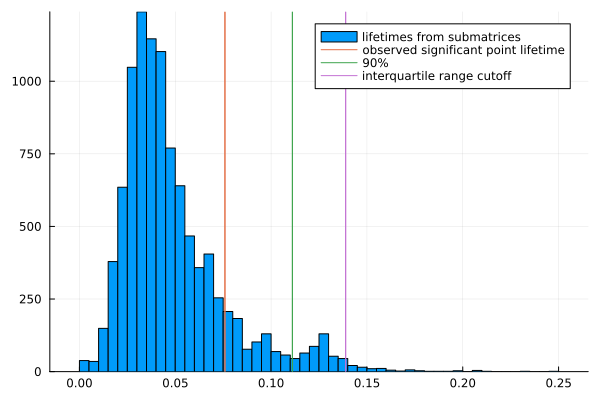

In [42]:
p = histogram(emp, label = "lifetimes from submatrices" )
vline!(p, [V1_sig, V1_sig], label = "observed significant point lifetime")
vline!(p, [min_length, min_length], label ="90%")
vline!(p, [cutoff, cutoff], label = "interquartile range cutoff")

Permutation test

In [46]:
function get_barlength_distribution(D; alpha = 0.05, n = 10)
    # find empirical distribution of bar lengths 
    # (permute matrix D and compute persistençce) x 10   
    # find barlength parameter l such that P(obeserving bar length >= l) <= alpha
    # D: Distance matrix
    # !!! SPEEDUP VIA MULTIPROCESSING
    length_sample = []
    for i =1:n
        D_perm = permute_symmetric_array(D)
        C_perm = eirene(D_perm)
        barc = Eirene_var.barcode(C_perm, dim=1)
        bar_lengths = barc[:,2]-barc[:,1]  
        append!(length_sample, mean(bar_lengths))
    end

    # replace NaN (resulting from empty barcodes) with 0
    length_sample_NaN = []
    for i in length_sample
        if isnan(i) == true
            append!(length_sample_NaN, 0)
        else
            append!(length_sample_NaN,i)
        end
    end

    # find barlength parameter l such that P(obeserving bar length >= l) <= alpha
    length_param = quantile(length_sample, 1-alpha)

    return length_param, length_sample

    # To plot histogram of sampled bar_lengths:
    #histogram(length_sample, label="", title="Histogram of bar lengths of shuffled distance", color = :grey)
    #vline!([length_param], label = "alpha = 0.05", linewidth = 5)
end

get_barlength_distribution (generic function with 1 method)

In [89]:
using Random

In [47]:
function permute_symmetric_array(D)
    # Permute a symmetric (dissimilarity) array whose diagonals are 0. 
    # "D": distance array
    
    # Columns of relevant entries
    #row 1: 2, ... , n
    #row 2: 3, ... , n  
    #row 3: 4, ... , n
    #    ...
    # row n-1: n

    # which have the following indices:
    # 2, ... , n
    # n+3, ... , 2n
    # 2n + 4, ... , 3n, 
    # ...
    # (n-1)n

    n = size(D, 1)
    
    # extract above-diagonal elements in order
    elements = []
    for i=1:n
        row = D[i,i+1:end]
        append!(elements, row)
    end

    # Indices of above-diagonal elements
    indices = []
    for i =1:n-1
        row_indices = collect(n*(i-1)+(i+1):i*n)
        append!(indices, row_indices)
    end

    # permute indices 
    perm_indices = shuffle(indices)

    # array with permuted indices
    D_perm = zeros(n,n)
    setindex!(D_perm, elements, perm_indices)

    # turn D_perm into a symmetric matrix 
    D_perm = D_perm + transpose(D_perm);
    
    return D_perm
end


permute_symmetric_array (generic function with 1 method)

In [55]:
D_perm = permute_symmetric_array(D_V1)

53×53 Matrix{Float64}:
 0.0       0.764885  0.586615  0.780735  …  0.68917   0.650892  0.882821
 0.764885  0.0       0.47442   0.608357     0.51842   0.732738  0.885737
 0.586615  0.47442   0.0       0.741195     0.699232  0.681877  0.740249
 0.780735  0.608357  0.741195  0.0          0.962616  0.441155  0.390053
 0.527399  0.733008  0.54693   0.818895     0.363332  0.565466  0.96251
 0.686672  0.396545  0.544773  0.660476  …  0.470522  0.909604  0.978705
 0.413941  0.515137  0.415156  0.699294     0.41951   0.860861  0.639507
 0.53144   0.349466  0.85949   0.818164     0.86401   0.710857  0.673234
 0.560553  0.605125  0.83719   0.714447     0.92966   0.666305  0.991768
 0.993526  0.686332  0.288036  0.661179     0.824153  0.768868  0.905214
 0.251717  0.927995  0.867029  0.585818  …  0.447295  0.991821  0.89978
 0.564847  0.565709  0.609576  0.415857     0.583358  0.656618  0.475096
 0.734197  0.921189  0.595326  0.456518     0.719489  0.31963   0.4183
 ⋮                              

In [52]:
length_param, length_sample = get_barlength_distribution(D_V1, n = 1000)

(0.11711374129186684, Any[0.09974604734209715, 0.1160552244845345, 0.117923230796046, 0.11142616580469974, 0.11222672411489272, 0.11072030673314368, 0.1026175992406069, 0.11072558638653933, 0.11390606700925943, 0.10706701213498979  …  0.11224950498114333, 0.11133354370134349, 0.10462183805321679, 0.09349120284122132, 0.10820950966938465, 0.10528831153845877, 0.0937695963113624, 0.1003806021838363, 0.1156060243051525, 0.11291940189749615])

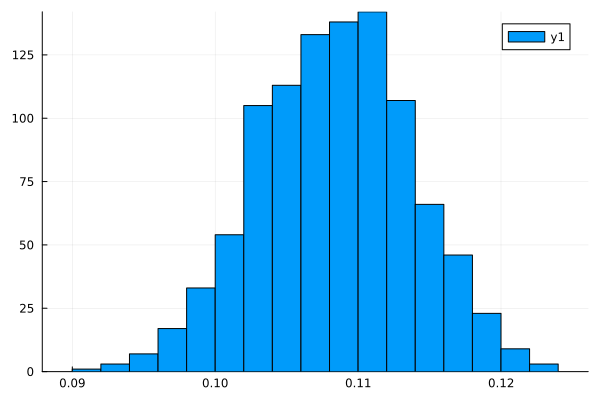

In [53]:
histogram(length_sample)

# 1. Subsampling
* Fasy et al, 2014 "Confidence sets for persistence diagrams"
* Note that the method, labeled "subsampling" in the paper, returns a very conservative confidence interval. The authors caution the reader to use this method only if the readers are comfortable with having conservative confidence intervals.

In [21]:
bottleneck_threshold, bottleneck_distances = get_PD_significance_threshold_subsampling(D_V1, n_samples = 500000)

LoadError: cannot assign a value to imported variable PersistenceDiagrams.threshold from module Main

In [ ]:
# save 
save("PD_significance_experiments/subsampling.jld2", "threshold", bottleneck_threshold, "bottleneck_distances", botlteneck_distances )

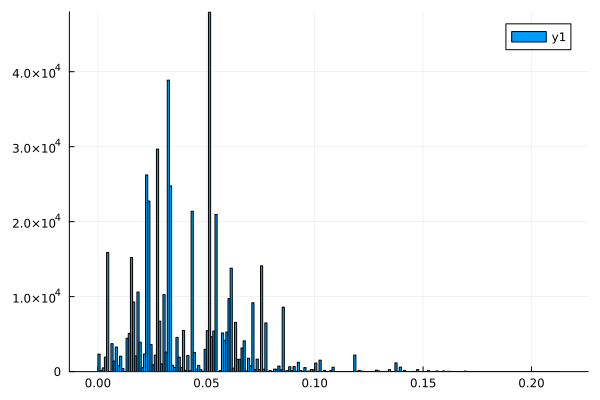

In [41]:
histogram(bottleneck_distances, label = "", xlabel = "bottleneck distances", ylabel = "frequency")
vline!()

In [42]:
min_length * sqrt(2)

0.10989217826949571

In [ ]:
# plot persistence diagrams
p1 = plot_PD(barcode_V1, title = "PD(VR(V1))", titlefontsize = 15)
# plot the threshold